In [ ]:
!pip3 install obci_readmanager

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 6.2MB 8.0MB/s 
  Created wheel for mne: filename=mne-0.17.2-cp37-none-any.whl size=6194576 sha256=29349c059512aeab9d7de94c450819762360ac6c6ffeb86357cffd735bc3f8f7
  Stored in directory: /root/.cache/pip/wheels/e4/be/8b/6b737d272fb91d42e7ac5d61cc93227df7d71944e0e0eb15dd
Successfully built mne


In [ ]:
#Importy
import pandas as pd
from obci_readmanager.signal_processing.read_manager import ReadManager
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import scipy.signal as ss
from  scipy.signal import freqz, group_delay #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import iirnotch
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów
from  scipy.signal import butter
import matplotlib.collections as collections

In [ ]:
#Ustawiam domyślne wielkości wykresów
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.linestyle": '--', "grid.linewidth": 0.5 })
plt.subplots_adjust(top = 1, bottom = 0.3, wspace=1, hspace=2)

<Figure size 1400x700 with 0 Axes>

In [ ]:
# Utwórz obiekt klasy ReadManager podając na wejściu
# ścieżki do odpowiednich plików
# Pobierz informacje o sygnale
'''
sampling = float(emg1.get_param("sampling_frequency"))
num_of_channels = int(emg1.get_param("number_of_channels"))
syg = emg1.get_microvolt_samples()
'''

'\nsampling = float(emg1.get_param("sampling_frequency"))\nnum_of_channels = int(emg1.get_param("number_of_channels"))\nsyg = emg1.get_microvolt_samples()\n'

2021-05-04 11:27:45,519 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


['LG', 'LD', 'PG', 'PD', 'TSS']
['Bip25', 'TSS']


2021-05-04 11:27:54,857 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


[{'start_timestamp': 20.792436838150024, 'end_timestamp': 22.779534101486206, 'name': 'prawo', 'channels': '', 'desc': {}}, {'start_timestamp': 27.222614765167236, 'end_timestamp': 29.210152864456177, 'name': 'prawo', 'channels': '', 'desc': {}}, {'start_timestamp': 35.07352423667908, 'end_timestamp': 37.060638427734375, 'name': 'prawo', 'channels': '', 'desc': {}}, {'start_timestamp': 41.5032913684845, 'end_timestamp': 43.496297121047974, 'name': 'lewo', 'channels': '', 'desc': {}}, {'start_timestamp': 47.83393859863281, 'end_timestamp': 49.821455001831055, 'name': 'lewo', 'channels': '', 'desc': {}}, {'start_timestamp': 55.600640296936035, 'end_timestamp': 57.58809971809387, 'name': 'prawo', 'channels': '', 'desc': {}}, {'start_timestamp': 61.78086304664612, 'end_timestamp': 63.77393698692322, 'name': 'lewo', 'channels': '', 'desc': {}}, {'start_timestamp': 68.61269354820251, 'end_timestamp': 70.59982204437256, 'name': 'lewo', 'channels': '', 'desc': {}}, {'start_timestamp': 75.59414

Text(0, 0.5, 'Napięcie [uV]')

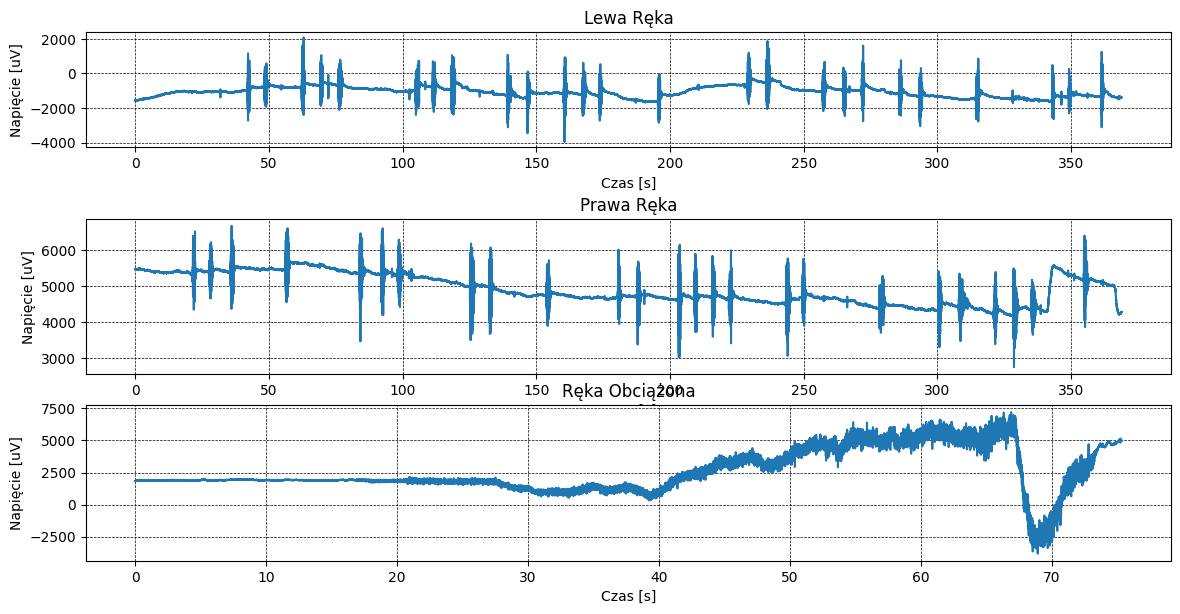

In [ ]:
#Filip
emg1 = ReadManager("Filip_rece.xml", "Filip_rece.raw", "Filip_rece.tag")
emg2 = ReadManager("kasia_z_ksiazka.xml", "kasia_z_ksiazka.raw", "kasia_z_ksiazka.tag")

channels_names_1 = emg1.get_param("channels_names")
channels_names_2 = emg2.get_param("channels_names")

print(channels_names_1)
print(channels_names_2)

# Pobierz cały, wybrany kanał
Lg = emg1.get_channel_samples("LG") * 0.0715
Ld = emg1.get_channel_samples("LD") * 0.0715
Rg = emg1.get_channel_samples("PG") * 0.0715
Rd = emg1.get_channel_samples("PD") * 0.0715

#Montaż
SL = Lg - Ld
SR = Rg - Rd

SLP = emg2.get_channel_samples("Bip25") * 0.0715

#Parametry podstawowe
Fs = 2048
T = len(SL)/Fs #SL = SR
dt = 1/Fs
t = np.arange(0,T,dt)
f = np.arange(0.01,Fs/2,0.01)

TP = len(SLP)/Fs 
tp = np.arange(0,TP,dt)

# Pobierz wszystkie znaczniki
tags1 = emg1.get_tags()
print(tags1)

tags2 = emg2.get_tags()
print(tags2)

#Plotuję surowe sygnały
plt.subplot(4,1,1)
plt.plot(t,SL)
plt.title('Lewa Ręka')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,2)
plt.plot(t,SR)
plt.title('Prawa Ręka')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(3,1,3)
plt.plot(tp,SLP)
plt.title('Ręka Obciążona')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

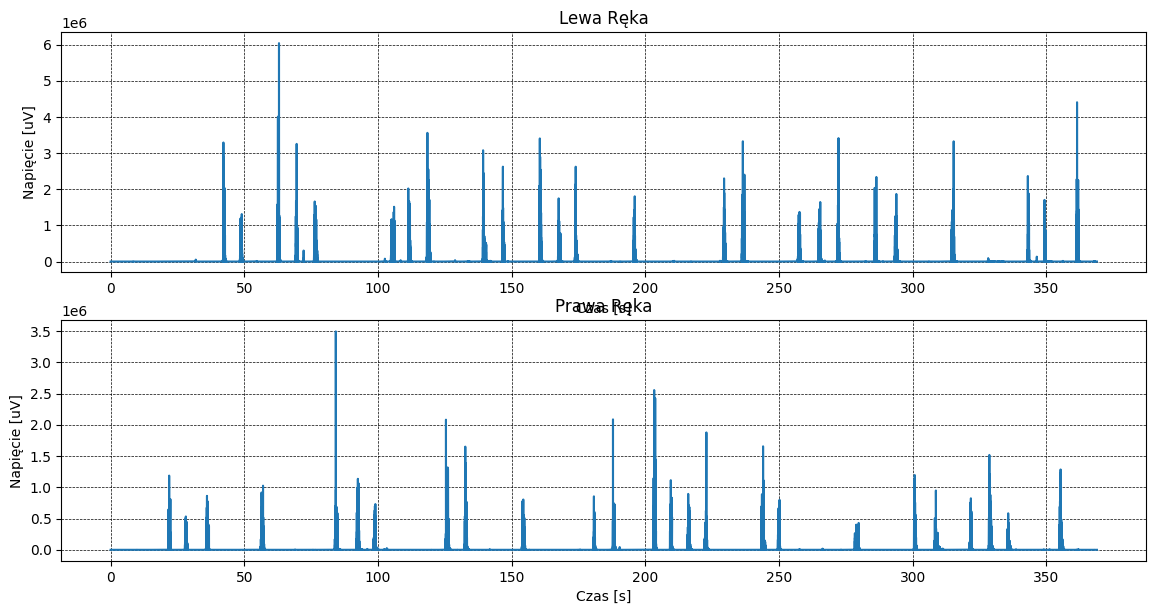

In [ ]:
sigs = [SL, SR]
def filtry(sigs:list=[]) -> list:
  filtered_channels = []
  for channel in sigs:
    [b1,a1]=butter(1,25,fs=Fs,btype='highpass')
    sf1 = filtfilt(b1, a1, channel)
    [b2,a2] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
    sf2 = filtfilt(b2, a2, sf1) #Notch
    sf2 = sf2**2
    filtered_channels.append(sf2)
  return filtered_channels

filtered_channels = filtry(sigs)

plt.subplot(2,1,1)
plt.plot(t,filtered_channels[0])
plt.title('Lewa Ręka')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(2,1,2)
plt.plot(t,filtered_channels[1])
plt.title('Prawa Ręka')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

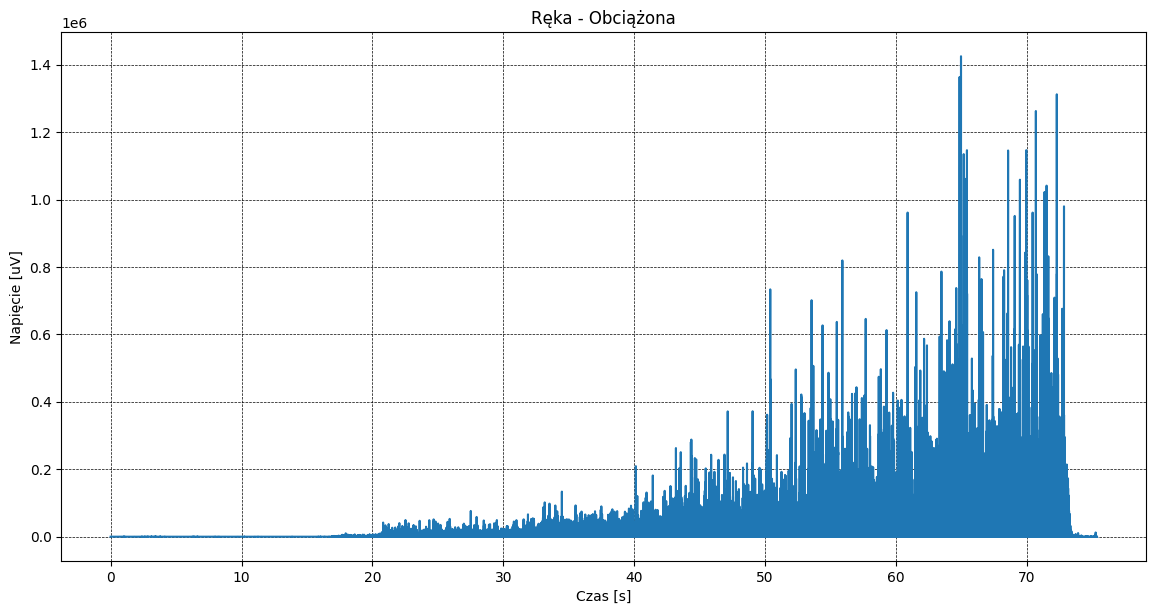

In [ ]:
sigsP = [SLP]
filtered_channelsP = filtry(sigsP)

plt.plot(tp,filtered_channelsP[0])
plt.title('Ręka - Obciążona')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

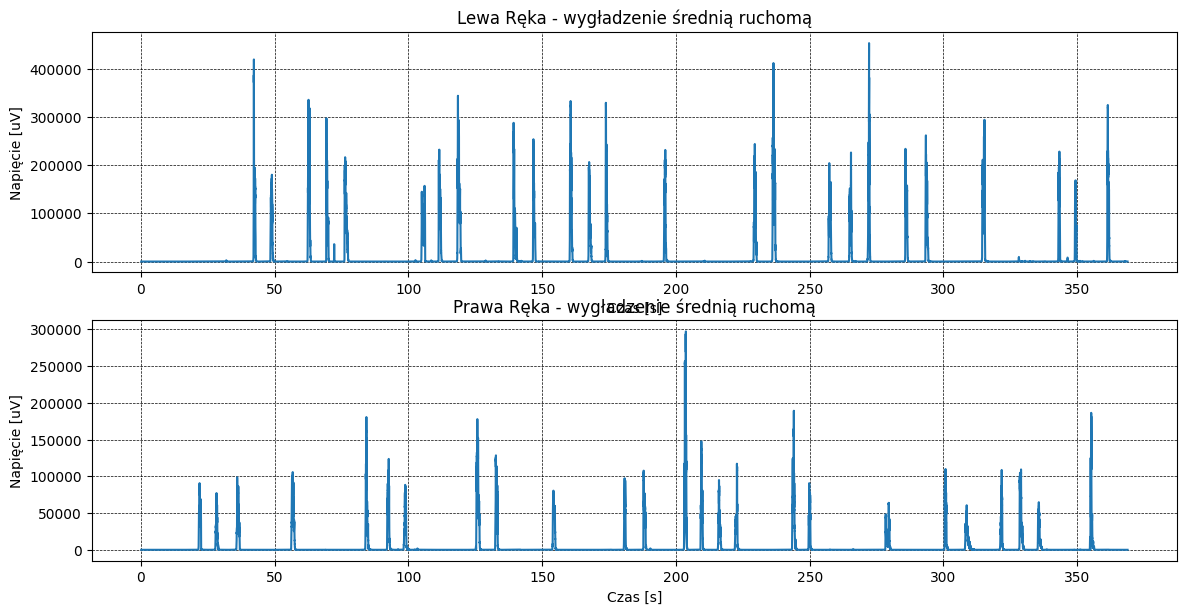

In [ ]:
def moving_average(syg, Fs, winlength):
  pds = pd.Series(syg)  
  windows = pds.rolling(int(winlength))  
  moving_averages = windows.mean()
  result = moving_averages.tolist()
  #result = result[int(winlength) - 1:]
  return result

Lma = moving_average(filtered_channels[0], Fs, winlength = 0.1*Fs)
Rma = moving_average(filtered_channels[1], Fs, winlength = 0.1*Fs)

plt.subplot(2,1,1)
plt.plot(t,Lma)
plt.title('Lewa Ręka - wygładzenie średnią ruchomą')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(2,1,2)
plt.plot(t,Rma)
plt.title('Prawa Ręka - wygładzenie średnią ruchomą')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

Text(0, 0.5, 'Napięcie [uV]')

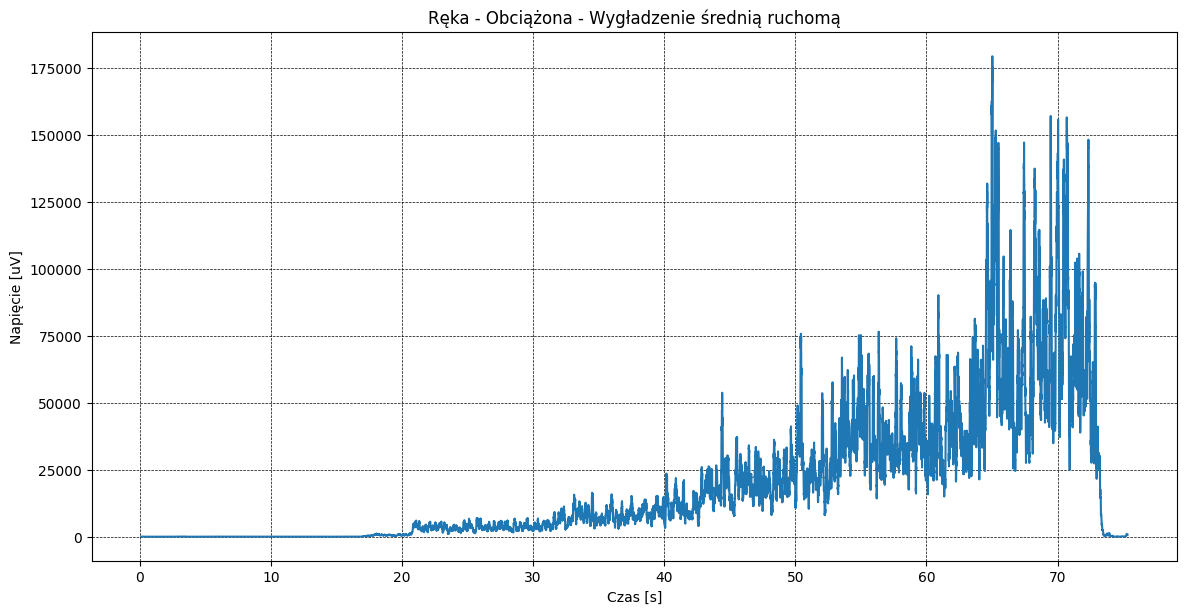

In [ ]:
LmaP = moving_average(filtered_channelsP[0], Fs, winlength = 0.1*Fs)

plt.plot(tp,LmaP)
plt.title('Ręka - Obciążona - Wygładzenie średnią ruchomą')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

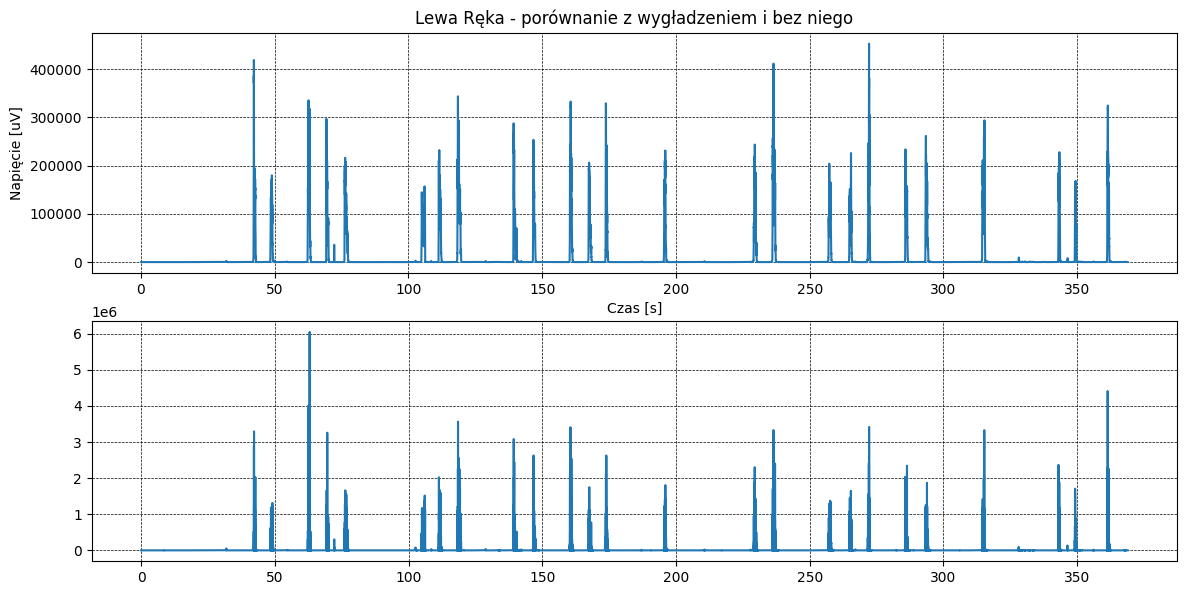

In [ ]:
#Porównanie
plt.subplot(2,1,1)
plt.plot(t,Lma)
plt.title('Lewa Ręka - porównanie z wygładzeniem i bez niego')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')
plt.subplot(2,1,2)
plt.plot(t,filtered_channels[0])

In [ ]:
def periodogram(s, okno , F_samp):
    '''peiodogram sygnału s
    okno - synał będzie przez nie przemnożony w czasie
    F_samp- częstość próbkowania'''
    s = s*okno
    N_fft = len(s)
    S = np.fft.rfft(s,N_fft)
    P = S*S.conj()/np.sum(okno**2)   
    P = P.real/Fs # P i tak ma zerowe wartości urojone, ale trzeba ykonać konwersję typów
    F = np.fft.rfftfreq(N_fft, 1/F_samp)
    if len(s)%2 ==0: # dokładamy Napięcie z ujemnej części widma 
        P[1:-1] *=2
    else:
        P[1:] *=2
    return (F,P)

In [ ]:
#Tagi
LTags = np.zeros(len(t))
RTags = np.zeros(len(t))
LTagsp = np.zeros(len(tp))

for item in tags1:
  if item['name'] == 'lewo':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    LTags[idx0:idx1] = 300000
  if item['name'] == 'prawo':
    idx2 =  int(item['start_timestamp']*Fs)
    idx3 =  int(item['end_timestamp']*Fs)
    RTags[idx2:idx3] = 150000

for item in tags2:
  if item['name'] == 'ksiazka':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    LTagsp[idx0:idx1] = 175000

srednie = []
s=[]
for ind in range(len(LTagsp)-1):
  if LTagsp[ind] != 0:
    s.append(LmaP[ind])
  if LTagsp[ind] != 0 and LTagsp[ind+1] == 0:
    s.append(LmaP[ind])
    srednie.append(s)
    s = []


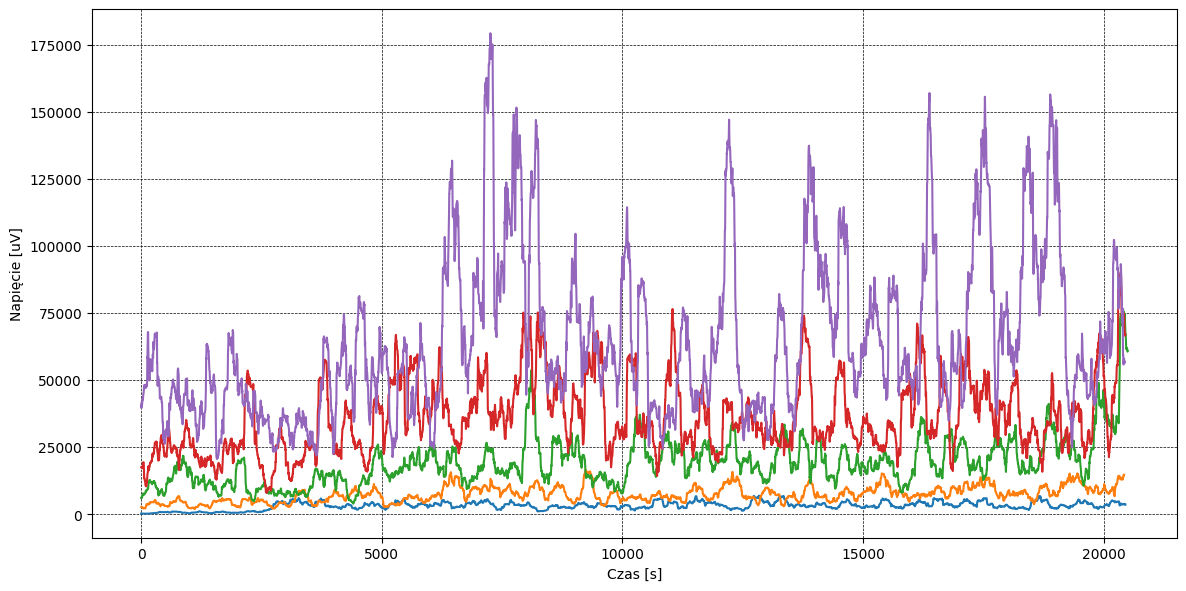

In [ ]:
for item in srednie:
  plt.plot(item)
  plt.xlabel('Czas [s]')
  plt.ylabel('Napięcie [uV]')

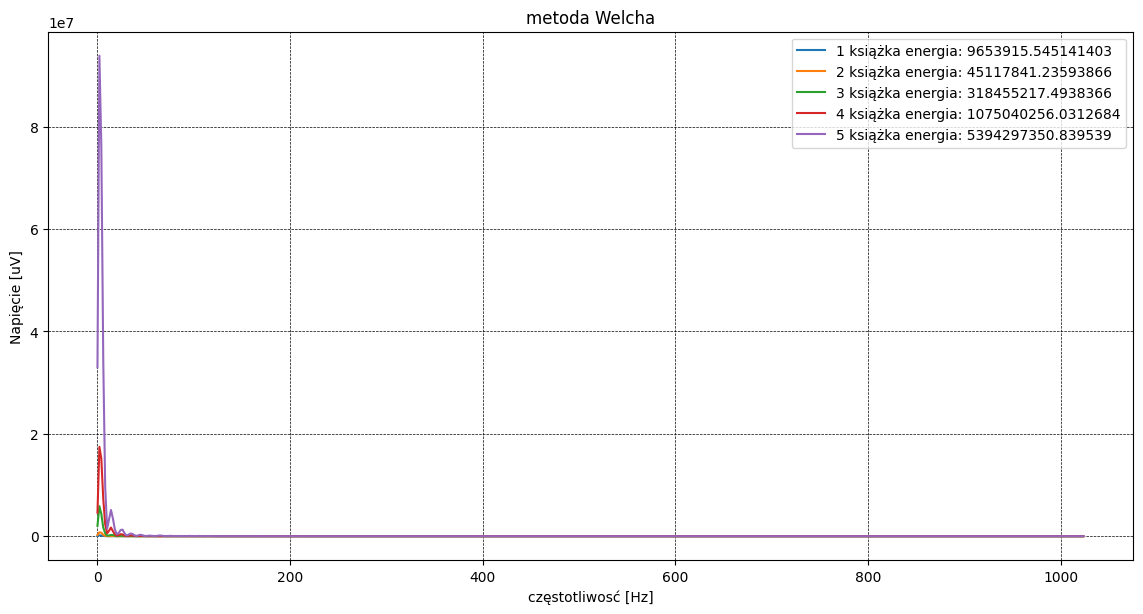

In [ ]:
from scipy.signal import welch
wykres = []
for item in srednie:
  okno = np.blackman(len(item)/20)
  okno/=np.linalg.norm(okno)
  '''
  F, P = periodogram(np.array(item), okno=okno, F_samp=Fs)
  plt.plot(item)
  plt.subplot(5,1,srednie.index(item)+1)
  plt.stem(F, P)
  plt.xlabel('Częstości [Hz]')
  plt.ylabel('Napięcie')
  '''  
  (F,P)= welch(np.array(item), fs=Fs, window=okno, nperseg=len(okno), noverlap=len(okno)//2, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
  plt.plot(F,P,label=str(srednie.index(item)+1)+' książka'+' energia: '+ str(20*np.sum(P)))
  plt.title('metoda Welcha')
  plt.xlabel('częstotliwosć [Hz]')
  plt.ylabel('Napięcie [uV]')
  plt.legend()
  F = None
  P = None
  wykres.append(np.mean(item))
  #wykres.append(np.std(item))

In [ ]:
plt.plot(wykres)

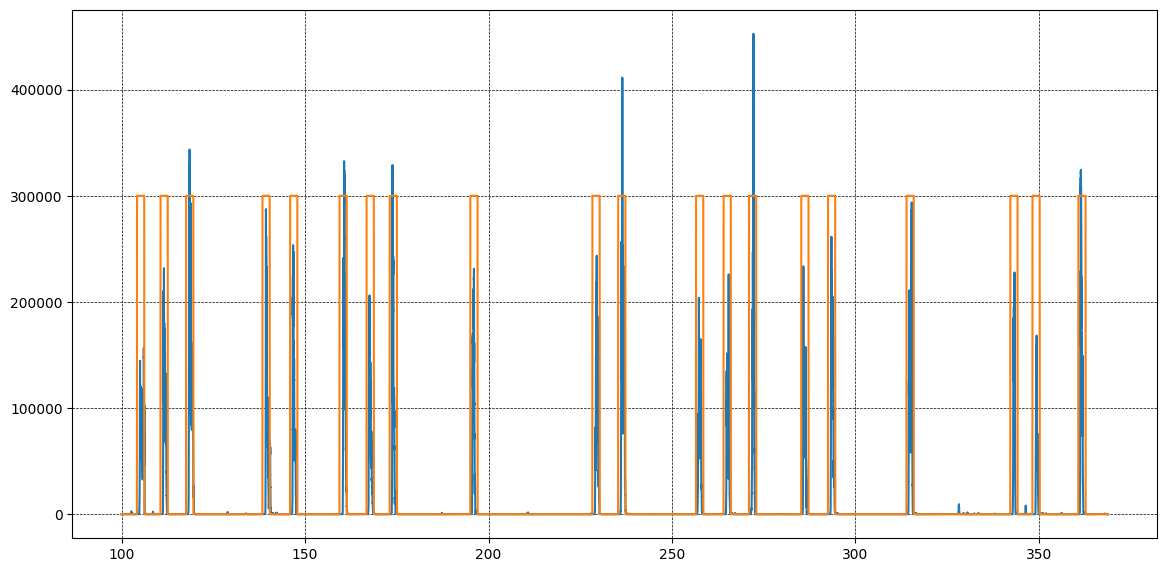

In [ ]:
plt.plot(t[100*Fs:],Lma[100*Fs:])
plt.plot(t[100*Fs:],LTags[100*Fs:])

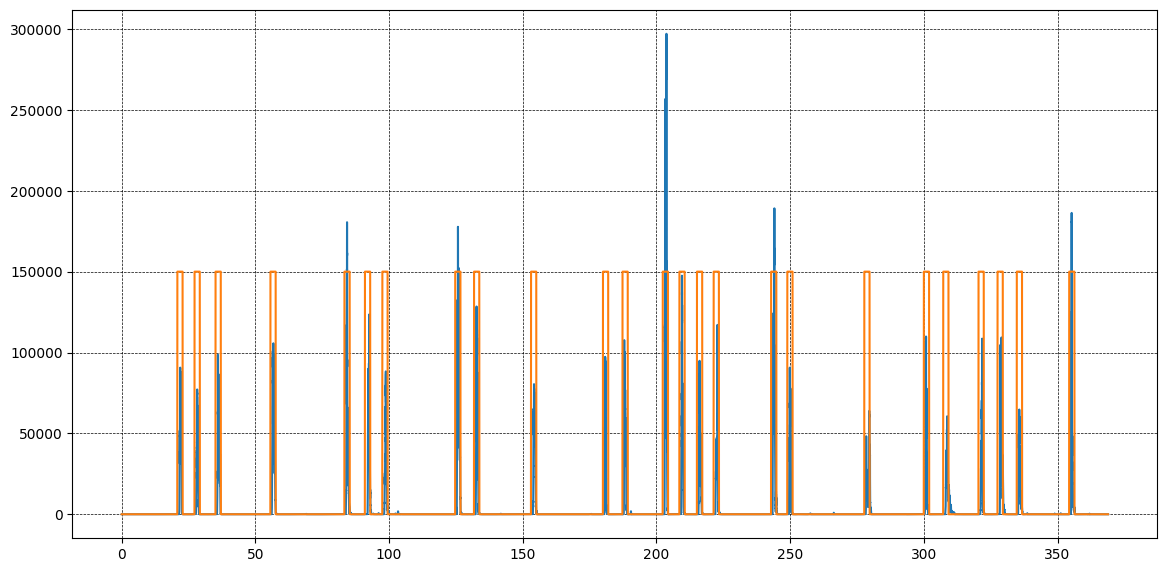

In [ ]:
plt.plot(t, Rma)
plt.plot(t, RTags)

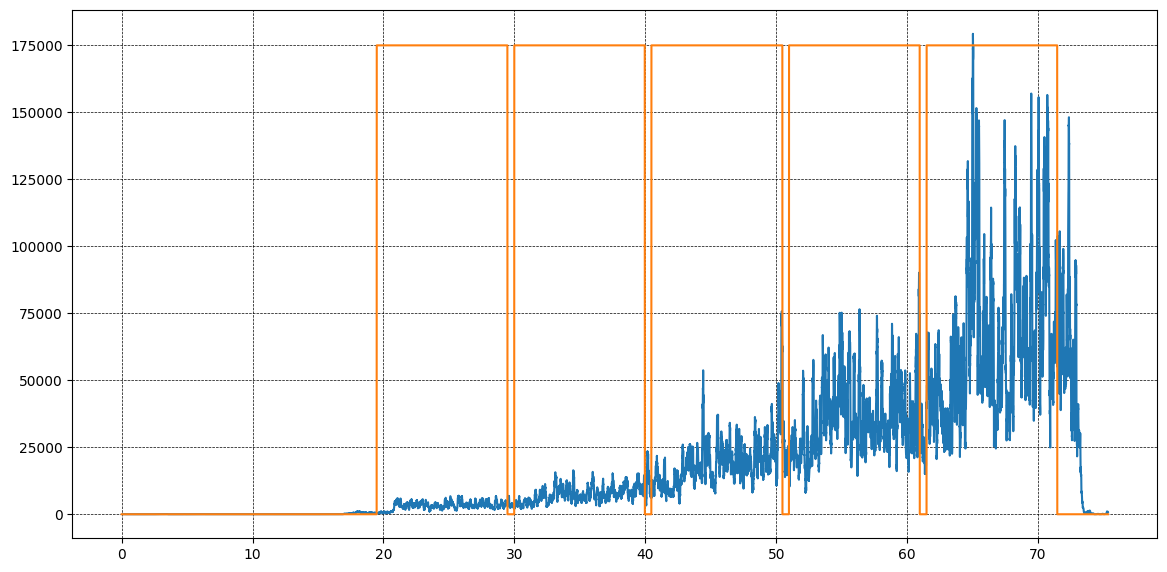

In [ ]:
plt.plot(tp, LmaP)
plt.plot(tp, LTagsp)

In [ ]:
import more_itertools as mit

def FindSequence(l, n, prog):
  l = list(l)
  indexes = [l.index(i) for i in l if i >= prog] #prog rozni sie dla montazy i kanalow ale lokalizacje pikow nie; można wyznaczać z histogramu
  r = [list(group) for group in mit.consecutive_groups(indexes)]
  result =  [group for group in r if len(group) >= n]
  return result

104


Text(0, 0.5, 'Napięcie [uV]')

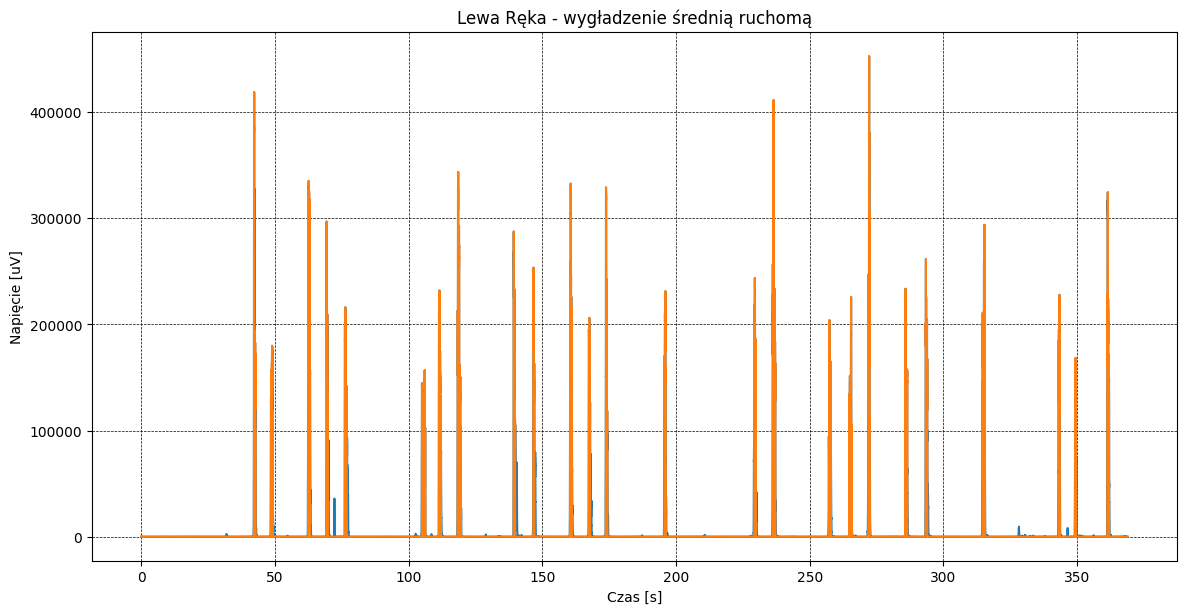

In [ ]:
#print(filtered_channels[2][400:450])
ind = FindSequence(Lma, n = 2, prog =100000)#chyba gubi krótkie piki przy 4 - bylo tyle samo dziur tu co pikow w odleglosciach
print(len(ind))
ss = list(Lma)
piki = np.zeros(len(Lma))
for seq in ind:
  for i in seq:
    piki[i] = ss[i]
plt.plot(t, Lma)
plt.plot(t, piki)#[400:700]
plt.title('Lewa Ręka - wygładzenie średnią ruchomą')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')

74


Text(0, 0.5, 'Napięcie [uV]')

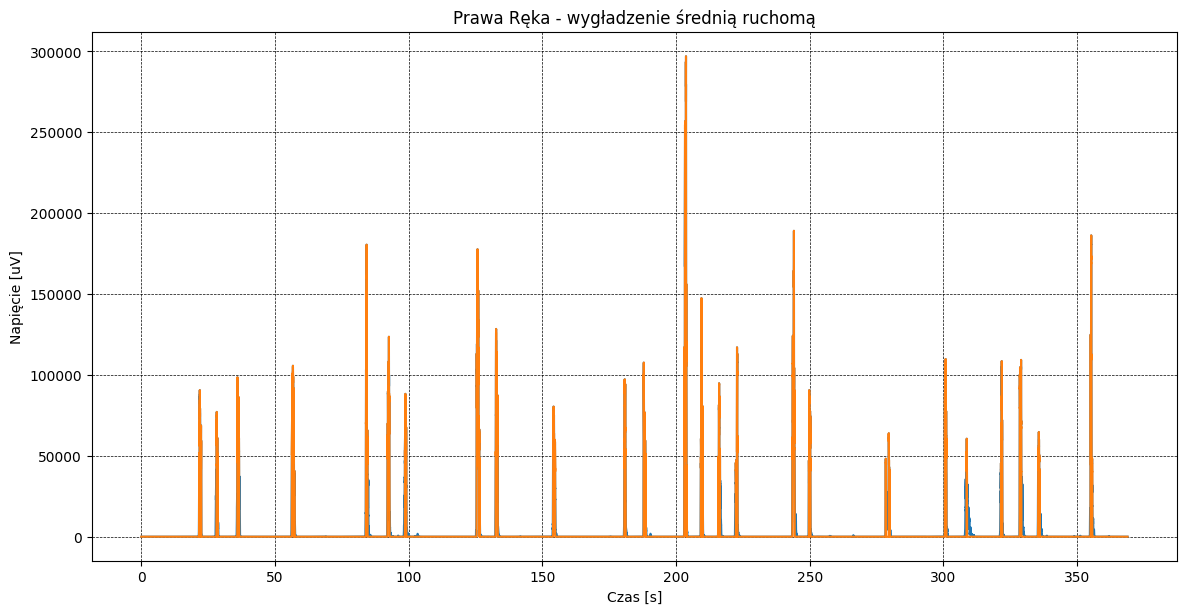

In [ ]:
ind = FindSequence(Rma, n = 3, prog =40000)#chyba gubi krótkie piki przy 4 - bylo tyle samo dziur tu co pikow w odleglosciach
print(len(ind))
ss = []
piki = []
ss = list(Rma)
piki = np.zeros(len(Rma))
for seq in ind:
  for i in seq:
    piki[i] = ss[i]
plt.plot(t, Rma)
plt.plot(t, piki)#[400:700]
plt.title('Prawa Ręka - wygładzenie średnią ruchomą')
plt.xlabel('Czas [s]')
plt.ylabel('Napięcie [uV]')